In [53]:
from datetime import date
today = date.today()

In [54]:
#stock = ['SPY', 'GLD', 'SPLB', 'EEM', 'QQQ', 'SLV', 'HYG', 'VWO', 'TLT', 'FXI']
stock = ['SPY']
sampling = ['daily', 'weekly'][0]
aggregation = ['last_day', 'mean'][0]
#stock = ['VTI', 'VEU', 'VNQ', 'BND', 'GSG']
date_start = '2010-01-01'
date_end = today.strftime("%Y-%m-%d")

In [55]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas_datareader as pdr
import statsmodels.api as sm
import scipy.stats as scs

In [168]:
combined_data = []
for i in range(len(stock)):
    df = pdr.DataReader(stock[i], 
                       start=date_start, 
                       end=date_end, 
                       data_source='yahoo')
    name = stock[i]
    df_stock = df[['Adj Close']]
    df_stock = df_stock.rename(columns={"Adj Close" : name})
    if i > 0:
        combined_data = pd.concat([combined_data, df_stock], axis = 1)
    else:
        combined_data = df_stock
        
    
    #combined_data.append(df_stock)
    #combined_data.append(df_stock)
    #combined_data = pd.concat([combined_data, df_stock], axis=1, join="inner" )
    #df1.append(df4, ignore_index=True, sort=False)
    #result = pd.concat([df1, df4], axis=1, join="inner")
if sampling == 'weekly':
    if aggregation == 'last_day':
        combined_data = combined_data.resample('W').agg('last')
    elif aggregation == "mean":
        combined_data = combined_data.resample('W').agg('mean')

In [169]:
combined_data

,SPY
Date,
2010-01-04,91.087418
2010-01-05,91.328552
2010-01-06,91.392838
2010-01-07,91.778671
2010-01-08,92.084045
...,...
2021-02-12,392.640015
2021-02-16,392.299988
2021-02-17,392.390015


<AxesSubplot:xlabel='Date'>

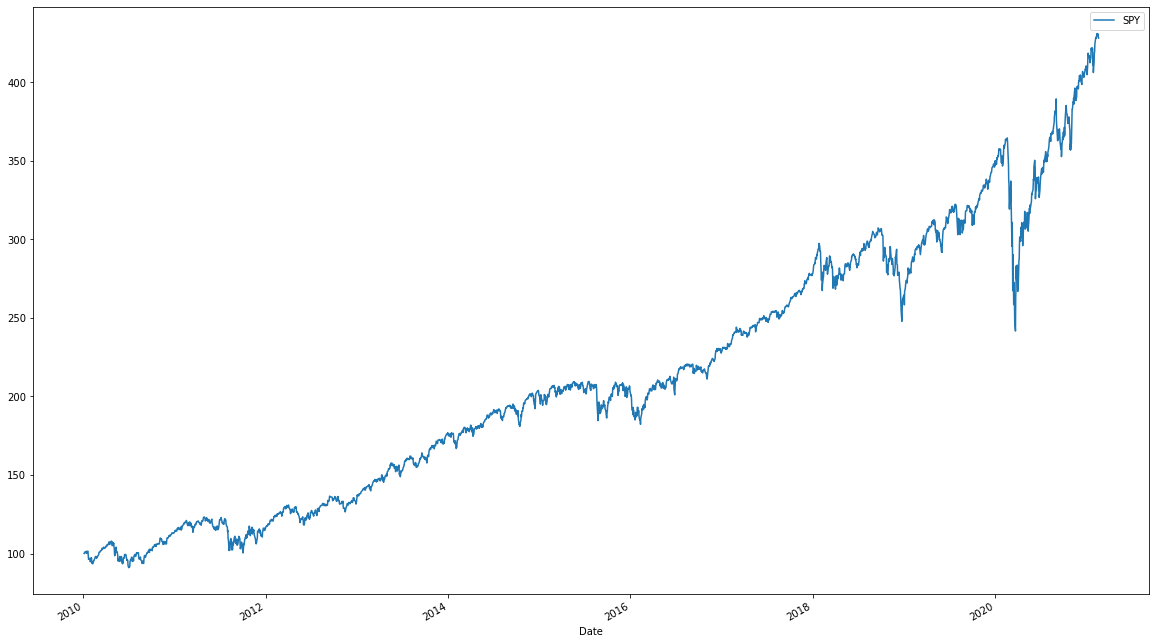

In [170]:
(combined_data / combined_data.iloc[0] * 100).plot(figsize=(20, 12))

In [171]:
combined_data['return'] = np.log(combined_data / combined_data.shift(1))
combined_data.dropna(inplace=True)
combined_data.head()

,SPY,return
Date,,
2010-01-05,91.328552,0.002644
2010-01-06,91.392838,0.000704
2010-01-07,91.778671,0.004213
2010-01-08,92.084045,0.003322
2010-01-11,92.212677,0.001396


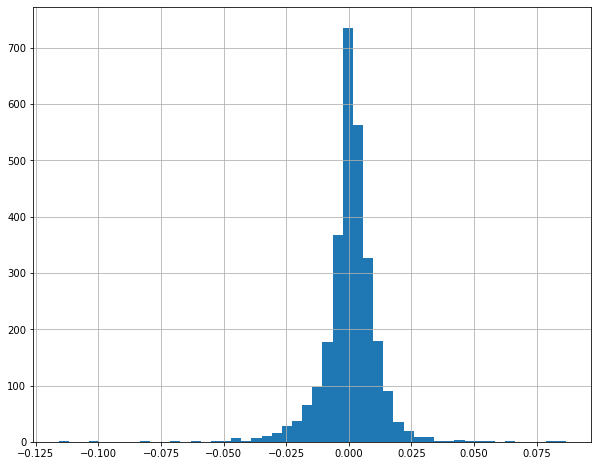

In [172]:
combined_data['return'].hist(bins=50, figsize=(10, 8));

# Linear Regression

In [173]:
lags = 3
cols = []
for lag in range(1, lags + 1):
    col = 'lag_{}'.format(lag)
    combined_data[col] = combined_data['return'].shift(lag)
    cols.append(col)
combined_data.dropna(inplace=True)

In [174]:
from sklearn.metrics import accuracy_score
from sklearn import linear_model

In [175]:
combined_data_linear = combined_data
combined_data_linear

,SPY,return,lag_1,lag_2,lag_3
Date,,,,,
2010-01-08,92.084045,0.003322,0.004213,0.000704,0.002644
2010-01-11,92.212677,0.001396,0.003322,0.004213,0.000704
2010-01-12,91.352661,-0.009370,0.001396,0.003322,0.004213
2010-01-13,92.124229,0.008411,-0.009370,0.001396,0.003322
2010-01-14,92.373383,0.002701,0.008411,-0.009370,0.001396
...,...,...,...,...,...
2021-02-12,392.640015,0.004928,0.001614,-0.000436,-0.000666
2021-02-16,392.299988,-0.000866,0.004928,0.001614,-0.000436
2021-02-17,392.390015,0.000229,-0.000866,0.004928,0.001614


In [176]:
lim = linear_model.LinearRegression()

In [177]:
combined_data_linear['pos_ols_1'] = lim.fit(combined_data_linear[cols], combined_data_linear['return']).predict(combined_data_linear[cols])

In [178]:
combined_data_linear[['pos_ols_1']] = np.where(combined_data_linear[['pos_ols_1']] > 0, 1, -1)

In [179]:
combined_data_linear['pos_ols_1'].value_counts()

 1.0    1931
-1.0     867
Name: pos_ols_1, dtype: int64

In [180]:
combined_data_linear['strat_ols_1'] = combined_data_linear['pos_ols_1'] * combined_data_linear['return']

In [181]:
accuracy_score(combined_data_linear['pos_ols_1'],
               np.sign(combined_data_linear['return']))

0.5546819156540386

In [182]:
combined_data_linear[['return', 'strat_ols_1']].sum().apply(np.exp)

return         4.249680
strat_ols_1    9.247396
dtype: float64

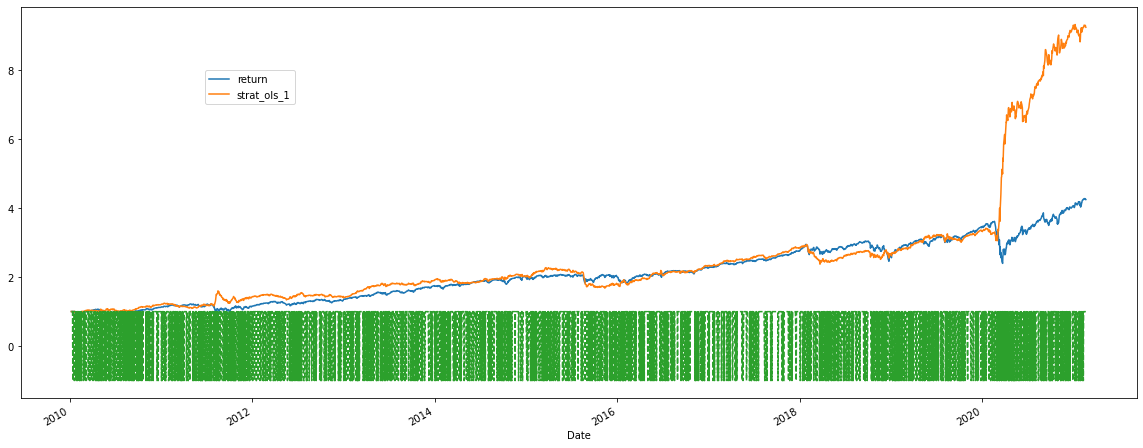

In [183]:
ax = combined_data_linear[['return', 'strat_ols_1']].cumsum().apply(np.exp).plot(
                                        figsize=(20, 8));
combined_data_linear['pos_ols_1'].plot(ax = ax, lw=1.5, secondary_y = 'Position', style = '--')
ax.get_legend().set_bbox_to_anchor((0.25,0.85));

# Logistic Regression

In [184]:
combined_data_logistic = combined_data

In [185]:
lm = linear_model.LogisticRegression(C=1e7, solver='lbfgs',
                                     multi_class='auto',
                                     max_iter=1000)

In [186]:
lm.fit(combined_data_logistic[cols], np.sign(combined_data_logistic['return']))

LogisticRegression(C=10000000.0, max_iter=1000)

In [187]:
combined_data_logistic['prediction'] = lm.predict(combined_data_logistic[cols])

In [188]:
combined_data_logistic['prediction'].value_counts()

 1.0    2745
-1.0      53
Name: prediction, dtype: int64

In [189]:
hits = np.sign(combined_data_logistic['return'].iloc[lags:] *
               combined_data_logistic['prediction'].iloc[lags:]
              ).value_counts()
hits

 1.0    1565
-1.0    1220
 0.0      10
dtype: int64

In [190]:
accuracy_score(combined_data_logistic['prediction'],
               np.sign(combined_data_logistic['return']))

0.5600428877769835

In [191]:
combined_data_logistic['strategy'] = combined_data_logistic['prediction'] * combined_data_logistic['return']

In [192]:
combined_data_logistic[['return', 'strategy']].sum().apply(np.exp)

return       4.249680
strategy    11.664222
dtype: float64

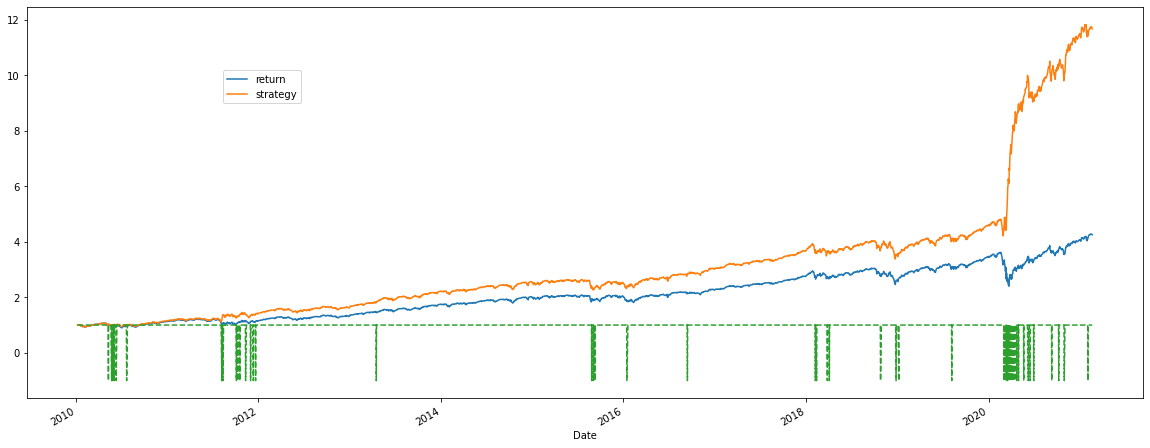

In [94]:
ax = combined_data_logistic[['return', 'strategy']].cumsum().apply(np.exp).plot(
                                        figsize=(20, 8));
combined_data_logistic['prediction'].plot(ax = ax, lw=1.5, secondary_y = 'Position', style = '--')
ax.get_legend().set_bbox_to_anchor((0.25,0.85));

In [143]:
combined_data_logistic

,SPY,return,lag_1,lag_2,lag_3,lin_prediction,prediction,strategy,pos_ols_1
Date,,,,,,,,,
2010-01-08,92.084045,0.003322,0.004213,0.000704,0.002644,0.103066,1.0,0.003322,LinearRegression()
2010-01-11,92.212677,0.001396,0.003322,0.004213,0.000704,0.117358,1.0,0.001396,LinearRegression()
2010-01-12,91.352661,-0.009370,0.001396,0.003322,0.004213,0.119504,1.0,-0.009370,LinearRegression()
2010-01-13,92.124229,0.008411,-0.009370,0.001396,0.003322,0.156823,1.0,0.008411,LinearRegression()
2010-01-14,92.373383,0.002701,0.008411,-0.009370,0.001396,0.061450,1.0,0.002701,LinearRegression()
...,...,...,...,...,...,...,...,...,...
2021-02-12,392.640015,0.004928,0.001614,-0.000436,-0.000666,0.112916,1.0,0.004928,LinearRegression()
2021-02-16,392.299988,-0.000866,0.004928,0.001614,-0.000436,0.105289,1.0,-0.000866,LinearRegression()
2021-02-17,392.390015,0.000229,-0.000866,0.004928,0.001614,0.134658,1.0,0.000229,LinearRegression()


In [160]:
combined_data_linear

,SPY,return,lag_1,lag_2,lag_3,pos_ols_1,strat_ols_1
Date,,,,,,,
2010-01-08,92.084045,0.003322,0.004213,0.000704,0.002644,1.0,0.003322
2010-01-11,92.212677,0.001396,0.003322,0.004213,0.000704,1.0,0.001396
2010-01-12,91.352661,-0.009370,0.001396,0.003322,0.004213,1.0,-0.009370
2010-01-13,92.124229,0.008411,-0.009370,0.001396,0.003322,1.0,0.008411
2010-01-14,92.373383,0.002701,0.008411,-0.009370,0.001396,-1.0,-0.002701
...,...,...,...,...,...,...,...
2021-02-12,392.640015,0.004928,0.001614,-0.000436,-0.000666,1.0,0.004928
2021-02-16,392.299988,-0.000866,0.004928,0.001614,-0.000436,1.0,-0.000866
2021-02-17,392.390015,0.000229,-0.000866,0.004928,0.001614,1.0,0.000229


In [153]:
combined_data

,SPY,return,lag_1,lag_2,lag_3
Date,,,,,
2010-01-08,92.084045,0.003322,0.004213,0.000704,0.002644
2010-01-11,92.212677,0.001396,0.003322,0.004213,0.000704
2010-01-12,91.352661,-0.009370,0.001396,0.003322,0.004213
2010-01-13,92.124229,0.008411,-0.009370,0.001396,0.003322
2010-01-14,92.373383,0.002701,0.008411,-0.009370,0.001396
...,...,...,...,...,...
2021-02-12,392.640015,0.004928,0.001614,-0.000436,-0.000666
2021-02-16,392.299988,-0.000866,0.004928,0.001614,-0.000436
2021-02-17,392.390015,0.000229,-0.000866,0.004928,0.001614


# Clustering